### 1. Load the dataset

**[1.1] Automatic reload modules**

In [1]:
%load_ext autoreload
%autoreload 2

**[1.2] Import packages**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump

**[1.3] Load the datasets**

In [3]:
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val   = pd.read_csv('../data/processed/X_val.csv')
X_test  = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
y_val   = pd.read_csv('../data/processed/y_val.csv')
y_test = pd.read_csv('../data/interim/y_test.csv')

### 2. Feature Engineering

* Based on feature importance done in the previous experiment, the least significant features will be excluded in this experiment.

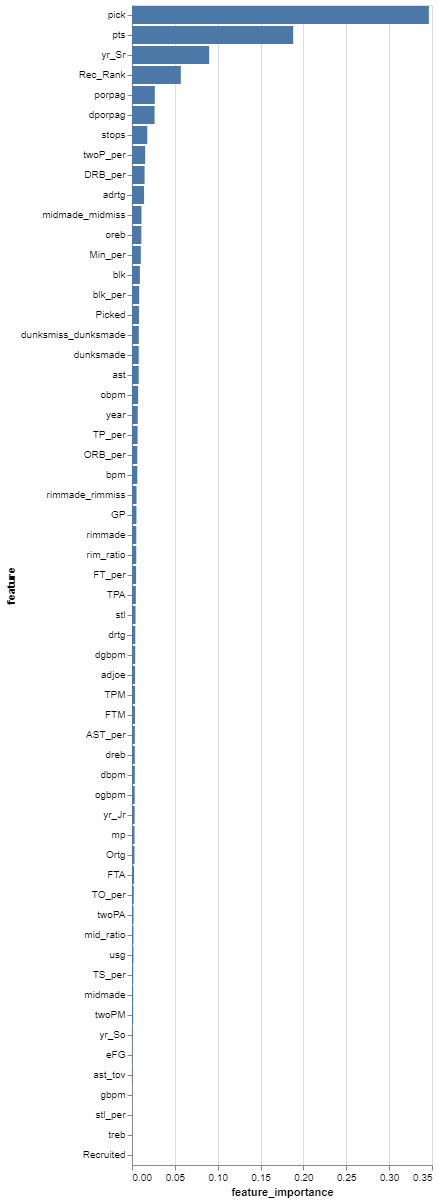

In [4]:
#list the features
X_train.columns

Index(['yr_Jr', 'yr_So', 'yr_Sr', 'GP', 'Min_per', 'Ortg', 'usg', 'eFG',
       'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FTA',
       'FT_per', 'twoPM', 'twoPA', 'twoP_per', 'TPM', 'TPA', 'TP_per',
       'blk_per', 'stl_per', 'porpag', 'adjoe', 'year', 'Rec_Rank', 'ast_tov',
       'rimmade', 'rimmade_rimmiss', 'midmade', 'midmade_midmiss', 'rim_ratio',
       'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'pick', 'drtg',
       'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp',
       'ogbpm', 'dgbpm', 'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts',
       'Picked', 'Recruited'],
      dtype='object')

In [5]:
to_keep = ['pick', 'yr_Jr', 'yr_So', 'yr_Sr', 'pts', 'Rec_Rank', 'porpag', 'dporpag', 
           'stops', 'twoP_per', 'DRB_per', 'adrtg', 'midmade_midmiss', 'oreb', 'Min_per',
           'blk', 'blk_per', 'dunksmade', 'dunksmiss_dunksmade', 'ast', 'obpm', 'year',
           'TP_per', 'ORB_per', 'bpm', 'rimmade_rimmiss', 'GP', 'rimmade']

In [6]:
X_train = X_train[to_keep]
X_val = X_val[to_keep]
X_test = X_test[to_keep]

X_train.columns

Index(['pick', 'yr_Jr', 'yr_So', 'yr_Sr', 'pts', 'Rec_Rank', 'porpag',
       'dporpag', 'stops', 'twoP_per', 'DRB_per', 'adrtg', 'midmade_midmiss',
       'oreb', 'Min_per', 'blk', 'blk_per', 'dunksmade', 'dunksmiss_dunksmade',
       'ast', 'obpm', 'year', 'TP_per', 'ORB_per', 'bpm', 'rimmade_rimmiss',
       'GP', 'rimmade'],
      dtype='object')

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(33001, 28)
(8251, 28)
(4970, 28)


In [8]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()

### 3. Train Gradient Boosting

**[3.1] Instantiate and fit the model**

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=8)

In [10]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=8)

**[2.2] Make prediction on training data**

In [11]:
y_train_pred = gb.predict_proba(X_train)[:, 1]
y_val_pred = gb.predict_proba(X_val)[:, 1]

**[2.3] Performance metric - AUROC**

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [13]:
print("Train - AUROC:\n", f'{roc_auc_score(y_train, y_train_pred):.4f}')
print("Val - AUROC:\n", f'{roc_auc_score(y_val, y_val_pred):.4f}')

Train - AUROC:
 0.9998
Val - AUROC:
 0.9984


**Plot the AUROC curve**

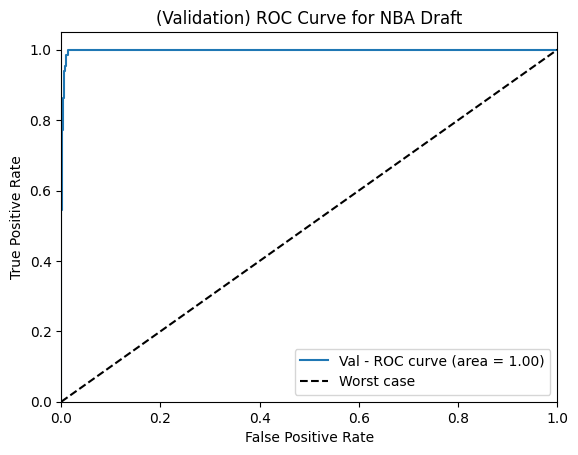

In [14]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Val - ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Worst case')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(Validation) ROC Curve for NBA Draft')
plt.legend()
plt.show()

**[2.4] Predict on test data**

In [15]:
y_test_pred = gb.predict_proba(X_test)[:, 1]

#Dataframe for pred result
y_pred = y_test
y_pred.loc[:, 'drafted'] = y_test_pred

print(y_pred.describe().round(5))

y_pred = pd.DataFrame(y_pred)

#Save the result to CSV file
y_pred.to_csv('../data/external/at1_pred_week3.2.csv', index=False)

          drafted
count  4970.00000
mean      0.00523
std       0.06298
min       0.00008
25%       0.00011
50%       0.00011
75%       0.00011
max       0.99843


### 3. Feature Importance

In [16]:
feature = gb.feature_importances_

In [17]:
#Dataframe of feature importance
feat_imp_rf_df = pd.DataFrame(
    {'feature': X_train.columns,
     'feature_importance': feature})

In [18]:
#Sort the dataframe
feat_imp_rf_df = feat_imp_rf_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)

In [19]:
#Visualize the feature importance
import altair as alt

alt.Chart(feat_imp_rf_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance']
)

alt.Chart(...)